In [1]:
#仿射变换
#存成五折交叉验证
#unet
#classfier

In [2]:
from __future__ import print_function, division
import numpy as np
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import keras as K
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
cd /home/chenxupeng/projects/pr

/home/chenxupeng/projects/pr


In [8]:
file = 'preprocess/forunet/segment/3_merge'
with h5py.File(file) as f:
    images = f['images'][:,:,:,:]
    masks = f['masks'][:,:,:,:]

In [12]:
print (images.shape)
print (masks.shape)

(2913, 1, 512, 512)
(2913, 1, 512, 512)


In [16]:
images[0,0].shape

(512, 512)

In [5]:
#augmentation

In [6]:
datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=3,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             channel_shift_range=0.2,
                             zoom_range=0.05,
                             horizontal_flip=False)

In [18]:
datagen.fit(images[:1,:,:,:])

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1, 1, 512, 512) (512 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [137]:
def augment_images(images,masks,batch_size):
    labels = np.arange(images.shape[0])
    data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=3,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     channel_shift_range=0.2,
                     zoom_range=0.05,
                     horizontal_flip=False,
                     data_format='channels_first')
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed =123
    image_datagen.fit(images,augment=True, seed=seed)
    mask_datagen.fit(masks,augment=True, seed=seed)
    X_aug = []
    Z_aug = []

    i_batch = 0
    for X, y in image_datagen.flow(images, labels, batch_size=batch_size,seed=seed):
        X_aug.append(X)  
        i_batch += 1
        if i_batch >= batch_size:
            break
    j_batch = 0
    for Z, y in image_datagen.flow(masks, labels, batch_size=batch_size,seed=seed):
        Z_aug.append(Z)  
        j_batch += 1
        if j_batch >= batch_size:
            break
    X_aug = np.vstack(X_aug)
    Z_aug = np.vstack(Z_aug)
    return X_aug,Z_aug

In [138]:
a ,b = augment_images(images[9:10,:,:,:],masks[9:10,:,:,:],10)

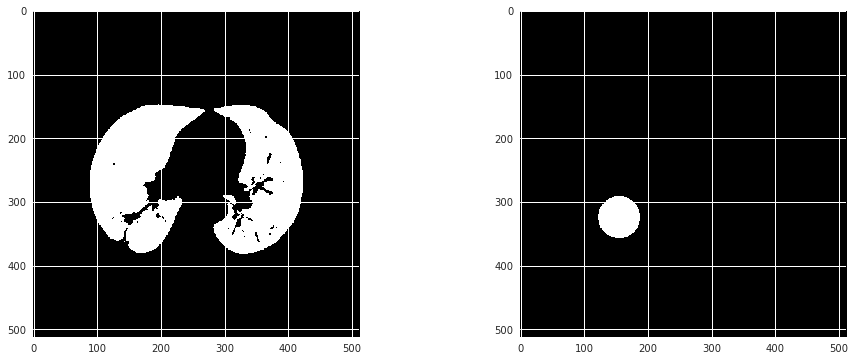

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(images[10,0,:,:],'bone')
ax[1].imshow(masks[10,0,:,:],'bone')
plt.show()

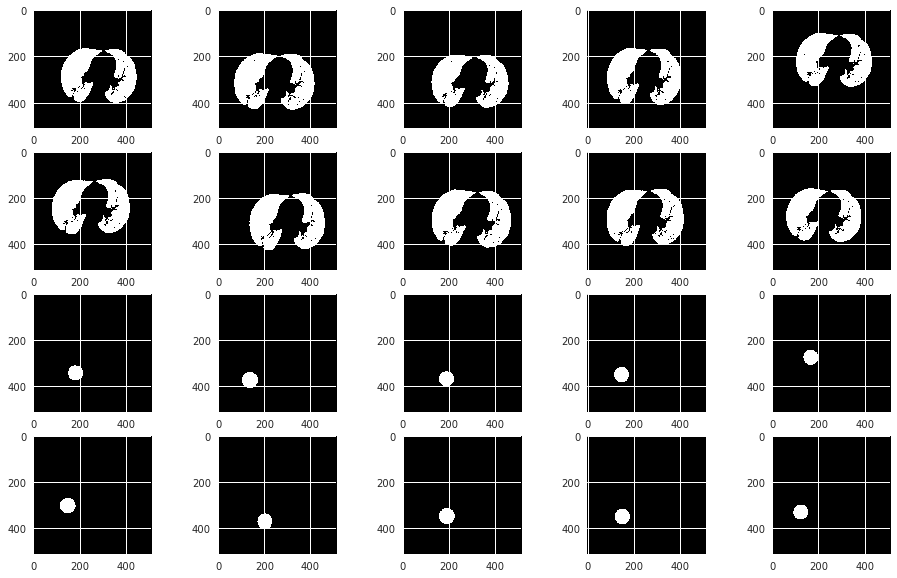

In [140]:
fig, ax = plt.subplots(4, 5, figsize=(16,10))
for i in range(5):
    for j in range(2):
        ax[j,i].imshow(a[2*i+j,0,:,:],'bone')
for t in range(5):
    for m in range(2):
        ax[2+m,t].imshow(b[2*t+m,0,:,:],'bone')
plt.show()

In [110]:
#mask也需要同步的变换才行!

In [141]:
aug_images = np.ndarray([images.shape[0]*10,1,512,512],dtype=np.float32)
aug_masks = np.ndarray([masks.shape[0]*10,1,512,512],dtype=np.float32)
for i in tqdm(range(images.shape[0])):
    a,b = augment_images(images[i:i+1,:,:,:],masks[i:i+1,:,:,:],10)
    for j in range(10):
        aug_images[10*i+j] = a[j]
        aug_masks[10*i+j] = b[j]


  0%|          | 0/2913 [00:00<?, ?it/s]

 10%|█         | 303/2913 [01:18<11:33,  3.76it/s]


 21%|██        | 605/2913 [02:34<09:55,  3.88it/s]


 31%|███       | 907/2913 [03:51<08:30,  3.93it/s]


 41%|████▏     | 1205/2913 [05:10<07:17,  3.91it/s]


 52%|█████▏    | 1501/2913 [06:30<05:56,  3.96it/s]


 62%|██████▏   | 1797/2913 [07:51<04:56,  3.76it/s]


 72%|███████▏  | 2093/2913 [09:14<03:30,  3.89it/s]


 82%|████████▏ | 2389/2913 [10:45<02:17,  3.81it/s]


 92%|█████████▏| 2685/2913 [12:05<01:02,  3.67it/s]


100%|██████████| 2913/2913 [13:11<00:00,  2.44it/s]


In [142]:
aug_imagesaug_images.shape)
print (aug_masks.shape)

(29130, 1, 512, 512)
(29130, 1, 512, 512)


In [143]:
with h5py.File('preprocess/forunet/segment/augment_merge') as f:
    f.create_dataset('images',data = aug_images)
    f.create_dataset('masks',data = aug_masks)

(1, 512, 512)

In [144]:
#构建Unet

In [146]:
#定义Dice coefficient：
smooth = 1.  
# Tensorflow version for the model  
def dice_coef(y_true, y_pred):  
    y_true_f = K.flatten(y_true)  
    y_pred_f = K.flatten(y_pred)  
    intersection = K.sum(y_true_f * y_pred_f)  
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)  
def dice_coef_loss(y_true, y_pred):  
    return -dice_coef(y_true, y_pred) 

In [151]:
cd bin

/home/chenxupeng/projects/pr/bin


In [11]:
from train_unet import *

In [159]:
#10-fold CV
#3_merge  augment_merge
with h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/3_merge') as f:
    images = f['images'][:,:,:,:]
    masks = f['masks'][:,:,:,:]


In [ ]:
index = np.arange(images.shape[0])
np.random.shuffle(index)
#check for nan and delete
a = []
for i in range(2913):
    if np.isnan(np.sum(images[i])):
        a.append(i)
nan = np.array(a)
index = np.setdiff1d(index,a)
#train test index:
train_index = {}
test_index = {}
num = int(np.floor(index.shape[0]/5.0))
for i in range(5):
    test_index[i] = index[num*i:num*(i+1)]
    train_index[i] = np.setdiff1d(index,test_index[i])
print (train_index[0].shape)
print (test_index[0].shape)
train_set_img = {}
test_set_img = {}
train_set_msk = {}
test_set_msk = {}
for i in range(5):
    train_set_img[i] =  images[train_index[i]]
    test_set_img[i] = images[test_index[i]]
    train_set_msk[i] =  masks[train_index[i]]
    test_set_msk[i] = masks[test_index[i]]

In [ ]:
train_set_img[0].shape

In [205]:
with h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/cv') as f:
    for i in range(5):
        f.create_dataset('images_train_'+str(i),data = train_set_img[i])
        f.create_dataset('images_test_'+str(i),data = test_set_img[i])
        f.create_dataset('masks_train_'+str(i),data = train_set_msk[i])
        f.create_dataset('masks_test_'+str(i),data = test_set_msk[i])

In [220]:
#augment_merge
with h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/augment_merge') as f:
    images = f['images'][:,:,:,:]
    masks = f['masks'][:,:,:,:]
index = np.arange(images.shape[0])
np.random.shuffle(index)
#check for nan and delete
a = []
for i in range(29130):
    if np.isnan(np.sum(images[i])):
        a.append(i)
nan = np.array(a)
index = np.setdiff1d(index,a)

In [221]:
#train test index:
train_index = {}
test_index = {}
num = int(np.floor(index.shape[0]/5.0))
for i in range(5):
    test_index[i] = index[num*i:num*(i+1)]
    train_index[i] = np.setdiff1d(index,test_index[i])
print (train_index[0].shape)
print (test_index[0].shape)

(21696,)
(5424,)


In [222]:
train_set_img = {}
test_set_img = {}
train_set_msk = {}
test_set_msk = {}
for i in range(5):
    train_set_img[i] =  images[train_index[i]]
    test_set_img[i] = images[test_index[i]]
    train_set_msk[i] =  masks[train_index[i]]
    test_set_msk[i] = masks[test_index[i]]

In [4]:
with h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/cv_augment') as f:
    for i in range(5):
        f.create_dataset('images_train_'+str(i),data = train_set_img[i])
        f.create_dataset('images_test_'+str(i),data = test_set_img[i])
        f.create_dataset('masks_train_'+str(i),data = train_set_msk[i])
        f.create_dataset('masks_test_'+str(i),data = test_set_msk[i])

NameError: name 'train_set_img' is not defined

In [28]:
#将编译并返回模型，并告诉keras在checkpoints保存模型的权重。 
#加载pretrained权重文件
model = get_unet(2)   
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True) 
#model.load_weights('/home/chenxupeng/projects/pr/kaggletutorial/unet.hdf5')

In [56]:
def Model(images_train,images_test,masks_train,masks_test_true):
    model.fit(images_train, masks_train, batch_size=20, nb_epoch=10,   
           verbose=1, shuffle=True,callbacks=[model_checkpoint]) 
    num_test = images_test.shape[0]
    masks_test = np.ndarray([num_test,1,512,512],dtype=np.float32) 
    predict = model.predict([images_test], verbose=0)
    for i in tqdm(range(num_test)): 
        masks_test[i] = predict[i]
    np.save('/home/chenxupeng/projects/pr/output/masksTestPredicted.npy', masks_test)  
    mean = 0.0  
    for i in range(num_test):  
        mean+=dice_coef_np(masks_test_true[i,0], masks_test[i,0])  
    mean/=num_test  
    print("Mean Dice Coeff : ",mean) 
    return mean

In [52]:
#model.fit(images_train[i][:20,:,:,:], masks_train[i][:20,:,:,:], batch_size=2, nb_epoch=1,   
#           verbose=1, shuffle=True,callbacks=[model_checkpoint]) 

In [53]:
#masks_test[0].shape

In [5]:
#准备数据
images_train = {}
images_test={}
masks_train={}
masks_test_true ={}
f =  h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/cv')
for i in range(5):
    images_train[i] = f['images_train_'+str(i)][:,:,:,:]  
    images_test[i] = f['images_test_'+str(i)][:,:,:,:]  
    masks_train[i] = f['masks_train_'+str(i)][:,:,:,:]  
    masks_test_true[i] =f['masks_test_'+str(i)][:,:,:,:]  

In [26]:
masks_test = np.ndarray([10,1,512,512],dtype=np.float32) 
masks_test[0:1].shape

(1, 1, 512, 512)

In [83]:
#mean = Model(images_train[i][:20,:,:,:],images_test[i][:20,:,:,:],masks_train[i][:20,:,:,:],masks_test_true[i][:20,:,:,:])

In [ ]:
#use multi gpu to solve the memory problem

In [58]:
#resize the image to 224 to reduce the memory cosume

In [59]:
from scipy.misc import imresize

In [66]:
imresize(images_train[i][0,0,:,:],(224,224)).shape

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


(224, 224)

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


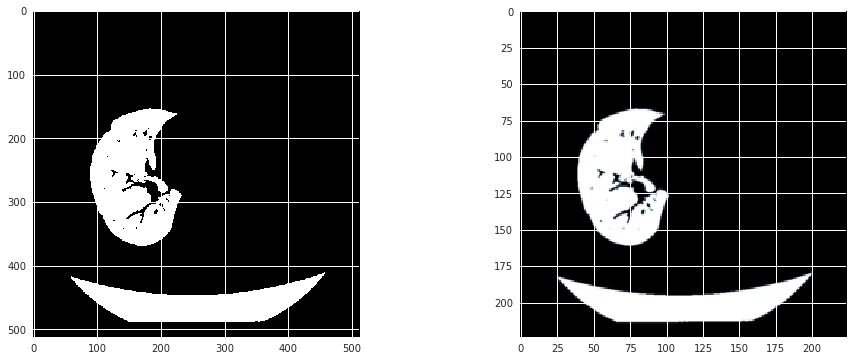

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(images_train[i][0,0,:,:],'bone')
ax[1].imshow(imresize(images_train[i][0,0,:,:],(224,224)),'bone')
plt.show()

In [70]:
def image_resize(image):
    image = imresize(image,(224,224))
    return image

In [75]:
images_train_ = np.ndarray([images_train[i].shape[0],1,224,224],dtype=np.float32)
images_test_= np.ndarray([images_test[i].shape[0],1,224,224],dtype=np.float32)
masks_train_ = np.ndarray([images_train[i].shape[0],1,224,224],dtype=np.float32)
masks_test_true_ = np.ndarray([images_test[i].shape[0],1,224,224],dtype=np.float32)
for j in tqdm(range(images_train[i].shape[0])):
    images_train_[j,0,:,:] =image_resize(images_train[i][j,0,:,:])
    masks_train_[j,0,:,:] =image_resize(masks_train[i][j,0,:,:])

  0%|          | 0/2170 [00:00<?, ?it/s]/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
100%|██████████| 2170/2170 [00:11<00:00, 177.95it/s]


In [77]:
images_train_[0].shape

(1, 224, 224)

In [14]:
#未归一化，可能因此训练不好。现在逐层归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(masks_train[0][0][0])

In [4]:
#准备数据
images_train = {}
images_test={}
masks_train={}
masks_test_true ={}

for i in range(5):
    f =  h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/cv_'+str(i)+'_224*224_minmax')
    images_train[i] = f['images_train_'+str(i)][:,:,:,:]  
    images_test[i] = f['images_test_'+str(i)][:,:,:,:]  
    masks_train[i] = f['masks_train_'+str(i)][:,:,:,:]  
    masks_test_true[i] =f['masks_test_'+str(i)][:,:,:,:]  

In [5]:
masks_test_true[i].shape

(542, 1, 224, 224)

In [4]:
cd /home/chenxupeng/projects/pr/

/home/chenxupeng/projects/pr


In [20]:
#定义Dice coefficient：
smooth = 0.  
# Tensorflow version for the model  
def dice_coef(y_true, y_pred):  
    y_true_f = K.flatten(y_true)  
    y_pred_f = K.flatten(y_pred)  
    intersection = K.sum(y_true_f * y_pred_f)  
    return (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) )  
def dice_coef_loss(y_true, y_pred):  
    return 1-dice_coef(y_true, y_pred) 
def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection ) / (np.sum(y_true_f) + np.sum(y_pred_f) )

In [11]:
#使用了新的loss function：
def dice_coef_loss(y_true, y_pred,alpha = 1):
    y, x = np.mgrid[:224, :224]
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    m = y_pred /K.sum(y_pred)
    sigma_x = K.sum((x - K.sum(x*m))**2*m)
    sigma_y = K.sum((y - K.sum(y*m))**2*m)
    loss = - (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) ) +alpha*(sigma_x*sigma_y)
    return loss

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) )

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection ) / (np.sum(y_true_f) + np.sum(y_pred_f))

In [4]:
#准备数据
images_train = {}
images_test={}
masks_train={}
masks_test_true ={}

for i in range(5):
    f =  h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/cv_'+str(i)+'_224*224_minmax')
    images_train[i] = f['images_train_'+str(i)][:,:,:,:]  
    images_test[i] = f['images_test_'+str(i)][:,:,:,:]  
    masks_train[i] = f['masks_train_'+str(i)][:,:,:,:]  
    masks_test_true[i] =f['masks_test_'+str(i)][:,:,:,:] 

In [6]:
from keras.callbacks import EarlyStopping
from train_unet_newloss import *
model = get_unet(2)   
#model_checkpoint = ModelCheckpoint('output/unet2.hdf5', monitor='loss', save_best_only=True) 
def Model(images_train,images_test,masks_train,masks_test_true,count):
    model.fit(images_train, masks_train, batch_size=16, nb_epoch=50,   
              verbose=1, shuffle=True,validation_split=0.2,
              callbacks=[EarlyStopping(monitor='val_loss', patience=4, verbose=0),TensorBoard(log_dir='/home/chenxupeng/projects/pr/output/tensorboard/unet/'+str(count)+'_1/log_dir')]) 
    num_test = images_test.shape[0]
    masks_test = np.ndarray([num_test,1,224,224],dtype=np.float32) 
    predict = model.predict([images_test], verbose=0)
    for i in tqdm(range(num_test)): 
        masks_test[i] = predict[i]
    np.save('/home/chenxupeng/projects/pr/output/masksTestPredicted_'+str(count)+'_1.npy', masks_test)  
    mean = 0.0  
    for i in range(num_test):  
        mean+=dice_coef_np(masks_test_true[i,0], masks_test[i,0])  
    mean/=num_test  
    print("Mean Dice Coeff : ",mean) 
    return mean

NameError: global name 'sigma' is not defined

In [7]:
print (images_train[i][:,:,:,:].shape)
print (images_test[i][:,:,:,:].shape)

(2170, 1, 224, 224)
(542, 1, 224, 224)


In [ ]:
sample_num_train = 1000
sample_num_test = 200
mean = {}
for i in tqdm(range(1)):
    mean[i] = Model(images_train[i][:sample_num_train,:,:,:],images_test[i][:sample_num_test,:,:,:],masks_train[i][:sample_num_train,:,:,:],masks_test_true[i][:sample_num_test,:,:,:],i)

  0%|          | 0/1 [00:00<?, ?it/s]/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 800 samples, validate on 200 samples
Epoch 1/50
144/800 [====>.........................] - ETA: 17s - loss: 4.0415e-04 - dice_coef: 0.0065

In [19]:
#model.save('output/unet2.hdf5')

In [ ]:
# Dice coefficient:
mean

In [ ]:
mean[0]

In [11]:
#查看分割效果  画到一张图上
masks_test[0][0].shape

(224, 224)

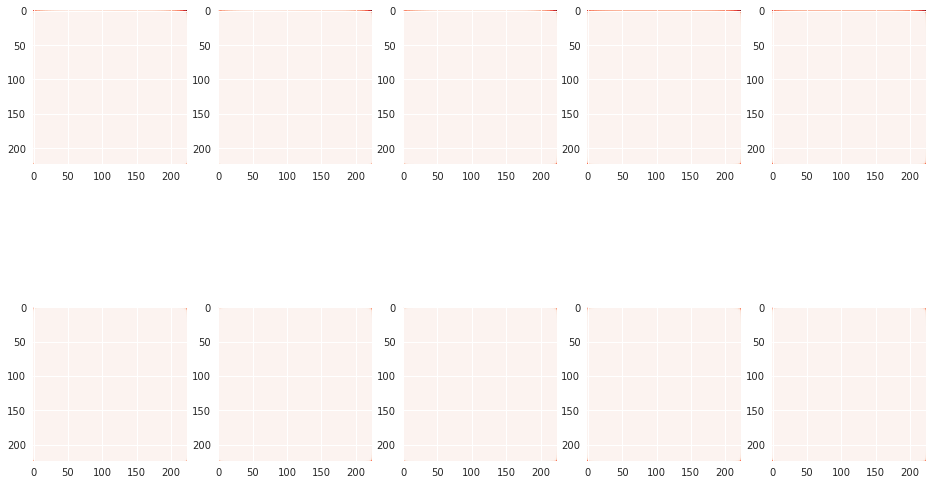

In [12]:
masks_test = np.load('/home/chenxupeng/projects/pr/output/masksTestPredicted_0_1.npy')
fig, ax = plt.subplots(2, 5, figsize=(16,10))
for i in range(5):
    for j in range(2):
        #ax[j,i].imshow(masks_test_true[0][10+2*i+j][0],'Blues',alpha = 0.9)
        ax[j,i].imshow(masks_test[10+2*i+j][0],'Reds',alpha = 0.9)
plt.show()

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1, 224, 224)   0                                            
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 1, 224, 224)   0           input_2[0][0]                    
____________________________________________________________________________________________________
lambda_4 (Lambda)                (None, 1, 224, 224)   0           input_2[0][0]                    
____________________________________________________________________________________________________
model_3 (Model)                  (None, 1, 224, 224)   1962337     lambda_3[0][0]                   
                                                                   lambda_4[0][0]          

In [21]:
cd /home/chenxupeng/projects/pr/output/

/home/chenxupeng/projects/pr/output


In [13]:
#用model做一些负样本的预测

In [11]:
path = '/home/chenxupeng/projects/pr/preprocess/forunet/images/nega_processed_3/'
name = np.loadtxt('/home/chenxupeng/projects/pr/preprocess/forunet/images/nega_processed_3/a.txt',dtype = "S")

In [18]:
count = 0
num_images = 0
for j in tqdm(range(name.shape[0])):
    imgs = np.load(path+name[j])
    num_images += imgs.shape[0]
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
for j in tqdm(range(name.shape[0])):
    imgs = np.load(path+name[j])
    if imgs.shape[0] ==512:
        for i in range(imgs.shape[0]):
            final_images[count+i][0] = imgs[i]
        count +=imgs.shape[0]
with h5py.File('preprocess/forunet/segment/nega_3_merge') as f:
    f.create_dataset('images',data = final_images)

100%|██████████| 975/975 [00:00<00:00, 1162.88it/s]


In [20]:
images_test = final_images

In [33]:
from scipy.misc import imresize
def image_resize(image):
    image = imresize(image,(224,224))
    return image
images_test_= np.ndarray([images_test.shape[0],1,224,224],dtype=np.float32)
for j in tqdm(range(images_test.shape[0])):
    images_test_[j,0,:,:] =image_resize(images_test[j,0,:,:])

  0%|          | 0/2925 [00:00<?, ?it/s]/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 2925/2925 [00:05<00:00, 542.28it/s]


In [42]:
nega_images_test= np.ndarray([images_test_.shape[0],1,224,224],dtype=np.float32)

In [43]:
nega_images_test.shape

(2925, 1, 224, 224)

In [44]:
#未归一化，可能因此训练不好。现在逐层归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
def image_resize(image):
    image_ = X_train_minmax = min_max_scaler.fit_transform(image)
    return image_
for t in tqdm(range(images_test_.shape[0])):
    nega_images_test[t,0,:,:] =image_resize(images_test_[t,0,:,:])

100%|██████████| 2925/2925 [00:01<00:00, 2074.97it/s]


In [46]:
with h5py.File('preprocess/forunet/nega_3_224*224') as f:
    f.create_dataset('images',data = nega_images_test)

In [45]:
nega_images_test.shape

(2925, 1, 224, 224)

In [ ]:
images_test = 

In [ ]:
num_test = images_test.shape[0]
predict = model.predict([images_test], verbose=0)
for i in tqdm(range(num_test)): 
    masks_test[i] = predict[i]
np.save('/home/chenxupeng/projects/pr/output/nega_masksTestPredicted_'+str(count)+'_1.npy', masks_test)  

In [5]:
cd /home/chenxupeng/projects/pr/

/home/chenxupeng/projects/pr


In [1]:
#划分augment的训练集与测试集

In [3]:
import h5py
import numpy as np

In [6]:
with h5py.File('preprocess/forunet/augment_merge_224*224_minmax') as f:
    images = f['images'][:,:,:,:]
    masks = f['masks'][:,:,:,:]

In [7]:
images.shape

(29130, 1, 224, 224)

In [ ]:
#不要随机打乱，三层存在一起

In [8]:
29130/3

9710

In [14]:
index = np.arange(images.shape[0]/3)

In [18]:
#check for nan and delete
a = []
for i in range(9710):
    if np.isnan(np.sum(images[i])):
        a.append(i)
nan = np.array(a)
index = np.setdiff1d(index,a)

In [19]:
np.random.shuffle(index)

In [21]:
index.shape

(9710,)

In [22]:
index_ = np.ndarray([29130,1])
for i in range(9710):
    index_[3*i] = index[i]*3
    index_[3*i+1] = index[i]*3+1
    index_[3*i+2] = index[i]*3+2

In [25]:
index_ = index_.flatten()

In [26]:
index = np.copy(index_)

In [29]:
index = index.astype('int')

In [30]:
index

array([23148, 23149, 23150, ..., 14646, 14647, 14648])

In [33]:
#train test index:
train_index = {}
test_index = {}
num = int(np.floor(index.shape[0]/10.0))
for i in range(10):
    test_index[i] = index[num*i:num*(i+1)]
    train_index[i] = np.setdiff1d(index,test_index[i])
print (train_index[0].shape)
print (test_index[0].shape)
train_set_img = {}
test_set_img = {}
train_set_msk = {}
test_set_msk = {}
for i in range(10):
    train_set_img[i] =  images[train_index[i]]
    test_set_img[i] = images[test_index[i]]
    train_set_msk[i] =  masks[train_index[i]]
    test_set_msk[i] = masks[test_index[i]]

(26217,)
(2913,)


In [35]:
for i in range(10):
    with h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/cv_'+str(i)+'_augment_minmax') as f:
        f.create_dataset('images_train',data = train_set_img[i])
        f.create_dataset('images_test',data = test_set_img[i])
        f.create_dataset('masks_train',data = train_set_msk[i])
        f.create_dataset('masks_test',data = test_set_msk[i])